## Start by importing the linear model and check the RMSLE:

In [2]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
lm = LinearRegression()

import statsmodels.api as sm

#Load our two Data Frames
AmesDummiesOrdinalCols = pd.read_csv('dave/AmesOrdinalManualAICFinal.csv', index_col=0)
AmesDummiesOrdinal = pd.read_csv('dave/AmesOrdinalManualFeatures.csv', index_col=0)

In [3]:
AmesDummiesOrdinalCols.shape

(1166, 62)

In [4]:
AmesDummiesOrdinalF = AmesDummiesOrdinal[list(AmesDummiesOrdinalCols.columns)]

In [5]:
#Trim AmesDummiesOrdinal to a DF containing only the selected Features:
AmesDF = AmesDummiesOrdinalF.copy()


In [6]:
#Transform AmesDF into the Train AmesDF
np.random.seed(19)
testIdxes = np.random.choice(range(1458), size=292, replace=False)
trainIdxes = list(set(range(1458))-set(testIdxes))

AmesDF2 = AmesDF.copy()
AmesDF = AmesDF.iloc[trainIdxes,]
AmesDFTest = AmesDF2.iloc[testIdxes,]

In [7]:
#Reindex the AmesDF:
AmesDF.index = range(1166)

In [8]:
#Run Linear Regression on the Overall (80%) train set, based on earlier K-fold:

#Create X and Y variables
X = AmesDF.drop('SalePrice', axis=1)
Y = AmesDF['SalePrice']

#Rename the true (20% untouched) test DFs
testX = AmesDFTest.drop('SalePrice', axis=1)
testY = AmesDFTest['SalePrice']

#Run the linear regression and check RMSLE:
lm.fit(X, Y)
lmscore = lm.score(X, Y)
lmpredict = lm.predict(X)

#Get scores for the Test set
lmtestscore = lm.score(testX, testY)
lmpredict = lm.predict(testX)

RMSLE = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(lmpredict), 2)))

print("The train R^2 score is: " + str(lmscore))
print("The test R^2 score is: " + str(lmtestscore))
print("The test RMSLE is: " + str(RMSLE))


The train R^2 score is: 0.9168239937634461
The test R^2 score is: 0.8780406865239571
The test RMSLE is: 0.16152859677890175


## Ridge regression:

In [9]:
#Ridge regression

from sklearn.linear_model import Ridge 
from sklearn import preprocessing

ridge_df=AmesDummiesOrdinalF.copy()

SalePrice_r=ridge_df.SalePrice
ridge_df=ridge_df.drop('SalePrice',axis=1)

#Standardize all input columns to 0-1
def standize_df(df,collist):
    for col in collist:
        stan_df=df[[col]]
        min_max_scaler = preprocessing.MinMaxScaler()
        standardized=min_max_scaler.fit_transform(stan_df)
        stan2_df=pd.DataFrame(standardized,columns=stan_df.columns,index=stan_df.index)
        df[[col]]=stan2_df
    return df


collist=list(ridge_df.columns)
ridge_df=standize_df(ridge_df,collist)

#Split to 80%-20% with seed 19
np.random.seed(19)
testIdxes = np.random.choice(range(1458), size= 292, replace=False)
trainIdxes = list(set(range(1458))-set(testIdxes))
rX = ridge_df.iloc[trainIdxes]
rtestX  = ridge_df.iloc[testIdxes]
rY = SalePrice_r.iloc[trainIdxes]
rtestY  = SalePrice_r.iloc[testIdxes]

# with 10 k-fold test, the best lambda=5.129
ridge=Ridge()
ridge.set_params(alpha=5.129)
ridge.fit(rX,rY)
rtrain_score=ridge.score(rX,rY)
rtest_score= ridge.score(rtestX,rtestY)

ridgepredict = ridge.predict(rtestX)
RMSLEvalue = np.sqrt(np.mean(np.power(np.log1p(rtestY)-np.log1p(ridgepredict), 2)))


print ('train_score(R2)\t',rtrain_score)
print ('test_score(R2) \t',rtest_score)
print ('Ridge RMSLE \t',RMSLEvalue)

train_score(R2)	 0.8978218675617993
test_score(R2) 	 0.8903082126135532
Ridge RMSLE 	 0.1431872146301889


## Now, import the Random Forest model and check the overall RMSLE:

In [10]:
#Run Random Forest on the Overall (80%) train set, based on earlier K-fold:


#Import RandomForestRegressor and set parameters to those found in the hyperparameter testing:
from sklearn import ensemble
randomForest = ensemble.RandomForestRegressor()
randomForest.set_params(bootstrap=False, max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, 
                        n_estimators=200)

#Run the linear regression and check RMSLE:
randomForest.fit(X, Y)
rfscore = randomForest.score(X, Y)
rfpredict = randomForest.predict(X)

#Get scores for the Test set
rftestscore = randomForest.score(testX, testY)
testpredictrf = randomForest.predict(testX)

RMSLErf = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(testpredictrf), 2)))

print("The train R^2 score is: " + str(rfscore))
print("The test R^2 score is: " + str(rftestscore))
print("The test RMSLE is: " + str(RMSLErf))

The train R^2 score is: 0.9999963950964745
The test R^2 score is: 0.9022970294049248
The test RMSLE is: 0.13365878761937738


## Now, import the Gradient Boost model and check the overall RMSLE:

In [11]:
#Run Gradient Boost on the Overall (80%) train set, based on earlier K-fold:

#Import GradientBoostRegressor and set parameters to those found in the hyperparameter testing:
from sklearn import ensemble
gradientBoost = ensemble.GradientBoostingRegressor()
gradientBoost.set_params(n_estimators=800, min_samples_split=6, min_samples_leaf=4, max_features='log2', max_depth=2, loss='huber')

#Run the linear regression and check RMSLE:
gradientBoost.fit(X, Y)
gbscore = gradientBoost.score(X, Y)
gbpredict = gradientBoost.predict(X)

#Get scores for the Test set
gbtestscore = gradientBoost.score(testX, testY)
testpredictgb = gradientBoost.predict(testX)

RMSLEgb = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(testpredictgb), 2)))

print("The train R^2 score is: " + str(gbscore))
print("The test R^2 score is: " + str(gbtestscore))
print("The test RMSLE is: " + str(RMSLEgb))

The train R^2 score is: 0.9711971211980962
The test R^2 score is: 0.9202133092265357
The test RMSLE is: 0.12447632076689859


## Combine (stack) these results to generate a prediction for SalePrice and see if it outperforms the gradient boosting prediction

In [12]:
stackedpredict = (testpredictgb + testpredictrf + lmpredict + ridgepredict)/4
RMSLEstacked = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(stackedpredict), 2)))
print("The balanced stacked-model RMSLE is: " + str(RMSLEstacked))

The balanced stacked-model RMSLE is: 0.12236817976007754


In [13]:
GradientPct = []
LinearPct = []
BoostPct = []
RidgePct = []
RMSLE = []
for i in list(range(20)):

    for j in list(range(20)):

        for k in list(range(20)):
            
            for l in list(range(20)):
            
                if i + j + k + l!= 20:
                    continue
                GradientPct.append(i)
                LinearPct.append(k)
                BoostPct.append(j)
                RidgePct.append(l)
            
                stackedpredict = (i*testpredictgb + j*testpredictrf + k*lmpredict + l*ridgepredict)/20
                RMSLEstacked = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(stackedpredict), 2)))
                RMSLE.append(RMSLEstacked)
                #print("gradient %: " + str(i) + ", randomforest%: " + str(j) + ", linear%: " + str(k) + ": RMSLE= " + str(RMSLEstacked))
    

In [14]:
Gradient = 5*pd.Series(GradientPct)
Linear = 5*pd.Series(LinearPct)
RandomForest = 5*pd.Series(BoostPct)
Ridge = 5*pd.Series(RidgePct)

RMSLESeries = pd.Series(RMSLE)

StackGridSearchDF = pd.DataFrame({'LinearPct':Linear, 'RidgePct':Ridge, 'RForestPct':RandomForest, 'GBoostPct':Gradient, 'RMSLE':RMSLESeries})

In [15]:
StackGridSearchDF.sort_values(by='RMSLE', axis=0, ascending=False).head()

,LinearPct,RidgePct,RForestPct,GBoostPct,RMSLE
18,95,5,0,0,0.158911
247,95,0,0,5,0.156523
17,90,10,0,0,0.156506
38,95,0,5,0,0.155055
16,85,15,0,0,0.154305


In [16]:
StackGridSearchDF.sort_values(by='RMSLE', axis=0).head()

,LinearPct,RidgePct,RForestPct,GBoostPct,RMSLE
1388,25,0,35,40,0.118986
1466,25,0,30,45,0.119025
1297,25,0,40,35,0.119062
1291,30,0,35,35,0.119062
1186,30,0,40,30,0.119101


In [17]:
#Make stackd model:
stackedpredict = (40*gradientBoost.predict(testX) + 35*randomForest.predict(testX) + 25*lm.predict(testX))/100

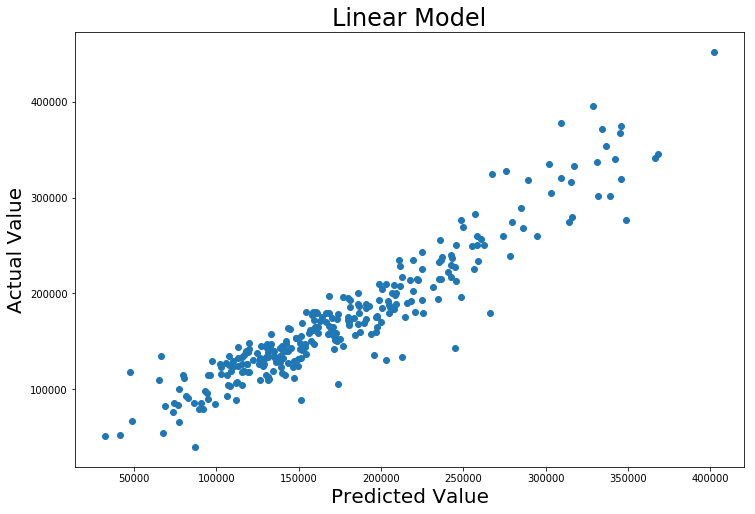

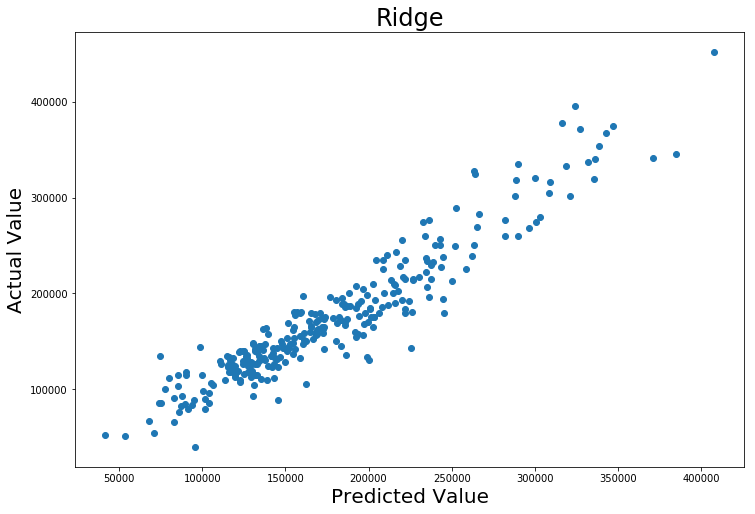

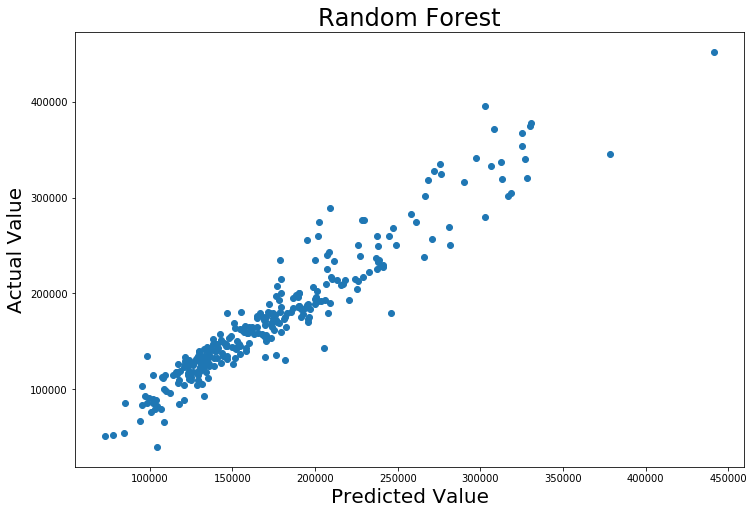

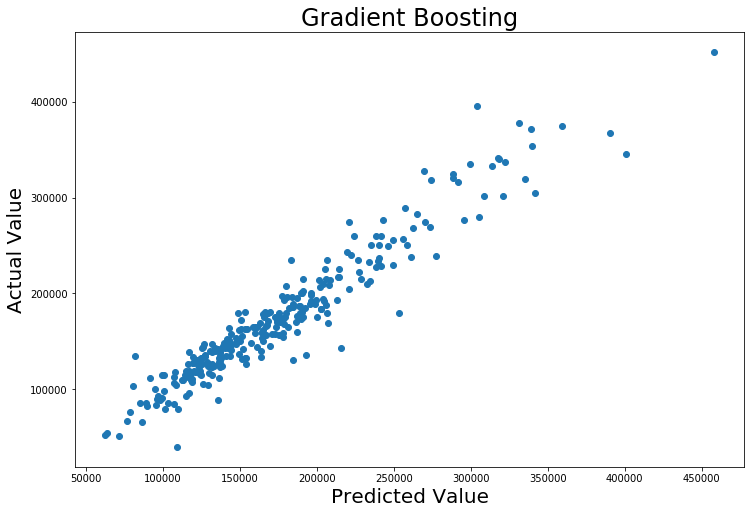

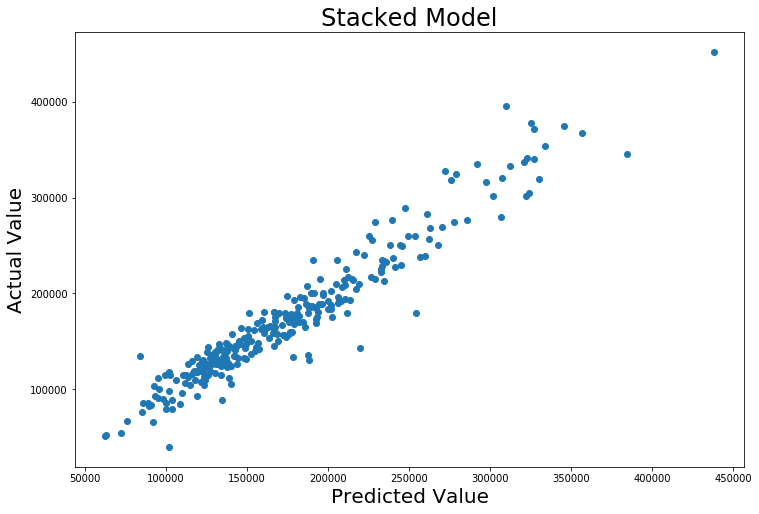

In [20]:
import matplotlib.pyplot as plt

for tup in [('Linear Model', lmpredict), ('Ridge', ridgepredict), ('Random Forest', testpredictrf), ('Gradient Boosting', testpredictgb), ('Stacked Model', stackedpredict)]:

    plt.figure(figsize=(12,8))
    plt.scatter(tup[1], testY)
    plt.xlabel('Predicted Value', fontsize=20)
    plt.ylabel('Actual Value', fontsize=20)
    plt.title(tup[0], fontsize=24)   
    plt.show()